In [1]:
# Standard library imports
import requests
import time

# Third-party imports
from matplotlib import pyplot as plt
from pprint import pprint
from iso3166 import countries
import pymongo
import numpy as np
import pandas as pd

In [2]:
# Reading the annual income by country from csv file
# Then find the latest income year and filter the data
# Drop duplicate countries

df=pd.read_csv('Data/annual_wages.csv')
df_1=df[['COUNTRY','Country','Time','Unit Code','Value']]
df_1.columns=['Country_code','Country','Year','Currency','Annual_income']
max=df_1['Year'].max()
income_df=df_1.loc[df_1['Year']==max]
income_df=income_df.drop_duplicates(subset=['Country'])
income_df.head()

,Country_code,Country,Year,Currency,Annual_income
19,AUS,Australia,2019,AUD,83602.47835
39,AUT,Austria,2019,EUR,44688.83284
59,BEL,Belgium,2019,EUR,47244.38417
79,CAN,Canada,2019,CAD,69174.86105
99,CZE,Czech Republic,2019,CZK,408211.25240


In [3]:
# Transform the data from source to standardise USD
# API call to converter all currencies to USD 
# Running first day/ last day of the year, then get the average (mean) exchange rate

rate=("https://api.exchangeratesapi.io/history?start_at=2019-01-01&end_at=2019-12-31&base=USD")
json = requests.get(rate).json()
rate_df=pd.DataFrame.from_dict(json['rates'])
avg_rate=rate_df.mean(axis=1)
avg_rate=avg_rate.to_frame()

# Save the currencries name to columns for merging
avg_rate['Currency']=avg_rate.index
avg_rate.columns=['Rate','Currency']

avg_rate.head()

,Rate,Currency
CAD,1.326937,CAD
HKD,7.835344,HKD
ISK,122.647084,ISK
PHP,51.793716,PHP
DKK,6.670257,DKK


In [4]:
# Look up the country currency and get the USD exchange rate
income1_df=income_df.merge(avg_rate,on='Currency')

# Convert the annual income to USD with exchange rate
income1_df['Income_USD']=income1_df['Annual_income']/income1_df['Rate']
income1_df.head()

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD
0,AUS,Australia,2019,AUD,83602.47835,1.439273,58086.613623
1,AUT,Austria,2019,EUR,44688.83284,0.893409,50020.596455
2,BEL,Belgium,2019,EUR,47244.38417,0.893409,52881.047124
3,FIN,Finland,2019,EUR,42617.54087,0.893409,47702.181469
4,FRA,France,2019,EUR,39099.26127,0.893409,43764.140735


In [5]:
# Running the iso3166 conversion to get 2 digits country codes and called alpha2
alpha2=[]
for country in income1_df['Country_code']:
    country2=countries.get(country)
    alpha2.append(country2.alpha2)    
    
income1_df['alpha2']=alpha2

income1_df.head()

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2
0,AUS,Australia,2019,AUD,83602.47835,1.439273,58086.613623,AU
1,AUT,Austria,2019,EUR,44688.83284,0.893409,50020.596455,AT
2,BEL,Belgium,2019,EUR,47244.38417,0.893409,52881.047124,BE
3,FIN,Finland,2019,EUR,42617.54087,0.893409,47702.181469,FI
4,FRA,France,2019,EUR,39099.26127,0.893409,43764.140735,FR


In [6]:
# Get the region list from isthereanydeal API 

r_region=requests.get('https://api.isthereanydeal.com/v01/web/regions/')
region_df=pd.DataFrame.from_dict(r_region.json()['data'])
region=list(region_df.columns) 

# As the European countries seperate in 2 regions, we pulled the data and called EU1/ EU2
eu1=pd.DataFrame.from_dict(r_region.json()['data']['eu1']['countries'])
eu2=pd.DataFrame.from_dict(r_region.json()['data']['eu2']['countries'])


eu2.head()

,0
0,BA
1,BG
2,HR
3,CY
4,CZ


In [7]:
# Add the column to identify which EU region 
for i in (eu1):
    eu1['region']="EU1"
    
for i in (eu2):
    eu2['region']="EU2"

# Append both EU1/EU2 together

eu_df=eu1.append(eu2)
eu_df.columns=['alpha2','eu_region']

eu_df.head()

,alpha2,eu_region
0,AL,EU1
1,AD,EU1
2,AT,EU1
3,BE,EU1
4,DK,EU1


In [8]:
#Look up which EU region countries located in Annual income dataframe

income1_df=pd.merge(income1_df,eu_df, on='alpha2',how='left')
income1_df.head()

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2,eu_region
0,AUS,Australia,2019,AUD,83602.47835,1.439273,58086.613623,AU,NaN
1,AUT,Austria,2019,EUR,44688.83284,0.893409,50020.596455,AT,EU1
2,BEL,Belgium,2019,EUR,47244.38417,0.893409,52881.047124,BE,EU1
3,FIN,Finland,2019,EUR,42617.54087,0.893409,47702.181469,FI,EU1
4,FRA,France,2019,EUR,39099.26127,0.893409,43764.140735,FR,EU1


In [9]:
# API call to isthereanydeal and pull the top x number of games
no=3
url = "https://api.isthereanydeal.com/v01/stats/popularity/chart/?"
key = "42c654a7eee83f02992f0317564462bceccdd585"
top_url = f"{url}key={key}&offset=0&&limit={no}"
response = requests.get(top_url).json()

In [10]:
# Convert json to dataframe
top_df=pd.DataFrame.from_dict(response['data'])
top_df.drop(columns=['rank'])

,position,title,plain
0,1,NieR: Automata,nierautomata
1,2,Stardew Valley,stardewvalley
2,3,Divinity: Original Sin 2 - Definitive Edition,divinityoriginalsiniidefinitiveedition


In [11]:
# API call to look up game price by region using game's name

price_df=pd.DataFrame()
currency_list=[]
region_list=[]
game_list=[]
session = requests.Session()

for index in top_df.plain:
    for i in region:
        url_2="https://api.isthereanydeal.com/v01/game/prices/?"
        price_url=f"{url_2}key={key}&plains={index}&shops=steam&region={i}"
        response_1 = requests.get(price_url).json()        
        price_dict=response_1['data']
        currency_list.append(response_1['.meta']['currency'])
        region_list.append(i.upper())
        game_list.append(index)
        price_df=price_df.append(price_dict[index]['list'],ignore_index=True)
        # Slow down the API call to avoid server reject
        time.sleep(1)
        print(f"{i} {response_1['.meta']['currency']} {index}")

eu1 EUR nierautomata
eu2 EUR nierautomata
uk GBP nierautomata
us USD nierautomata
ca CAD nierautomata
br2 BRL nierautomata
au2 AUD nierautomata
ru RUB nierautomata
tr TRY nierautomata
cn CNY nierautomata
eu1 EUR stardewvalley
eu2 EUR stardewvalley
uk GBP stardewvalley
us USD stardewvalley
ca CAD stardewvalley
br2 BRL stardewvalley
au2 AUD stardewvalley
ru RUB stardewvalley
tr TRY stardewvalley
cn CNY stardewvalley
eu1 EUR divinityoriginalsiniidefinitiveedition
eu2 EUR divinityoriginalsiniidefinitiveedition
uk GBP divinityoriginalsiniidefinitiveedition
us USD divinityoriginalsiniidefinitiveedition
ca CAD divinityoriginalsiniidefinitiveedition
br2 BRL divinityoriginalsiniidefinitiveedition
au2 AUD divinityoriginalsiniidefinitiveedition
ru RUB divinityoriginalsiniidefinitiveedition
tr TRY divinityoriginalsiniidefinitiveedition
cn CNY divinityoriginalsiniidefinitiveedition


In [12]:
# Add back the currency/ region/game to the dataframe as it is under different dictionary of json
price_df['currency']=currency_list   
price_df['region']=region_list   
price_df['game']=game_list   

In [13]:
# Copying the dataframe to avoid another API call
test_df=price_df

In [14]:
# Calculate the average game price by region using groupby

data_df=test_df.groupby(by='region').mean()
data_df['alpha2']=data_df.index
data_df['avg_price']=(data_df['price_new']+data_df['price_old'])/2
data_df=data_df.drop(['price_new','price_old','price_cut'],axis=1)
data_df

,alpha2,avg_price
region,,
AU2,AU2,43.146667
BR2,BR2,74.326667
CA,CA,41.826667
CN,CN,151.666667
EU1,EU1,32.990000
EU2,EU2,31.990000
RU,RU,810.000000
TR,TR,77.333333
UK,UK,23.656667


In [15]:
# Rename the country code from api to standard format as it has different naming
data_df=data_df.replace(to_replace="AU2",value="AU")
data_df=data_df.replace(to_replace="BR2",value="BRL")

In [16]:
# Copy dataframe to avoid API call
data_df1=data_df

In [17]:
# Merging the dataframe with the average(mean) game price to the annual income dataframe
income2_df=pd.merge(income1_df,data_df1, on='alpha2',how='left')
income2_df.head()

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2,eu_region,avg_price
0,AUS,Australia,2019,AUD,83602.47835,1.439273,58086.613623,AU,NaN,43.146667
1,AUT,Austria,2019,EUR,44688.83284,0.893409,50020.596455,AT,EU1,NaN
2,BEL,Belgium,2019,EUR,47244.38417,0.893409,52881.047124,BE,EU1,NaN
3,FIN,Finland,2019,EUR,42617.54087,0.893409,47702.181469,FI,EU1,NaN
4,FRA,France,2019,EUR,39099.26127,0.893409,43764.140735,FR,EU1,NaN


In [18]:
# Rename dataframe columns for easier merging
data_df.columns=['eu_region','avg_price']
data_df

,eu_region,avg_price
region,,
AU2,AU,43.146667
BR2,BRL,74.326667
CA,CA,41.826667
CN,CN,151.666667
EU1,EU1,32.990000
EU2,EU2,31.990000
RU,RU,810.000000
TR,TR,77.333333
UK,UK,23.656667


In [19]:
# Merging the average game price just for European countries and saved as euro_df
euro_df=pd.merge(income1_df,data_df, on='eu_region',how='left')
euro_df=euro_df.dropna(subset=['avg_price'])
euro_df.head()

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2,eu_region,avg_price
1,AUT,Austria,2019,EUR,44688.83284,0.893409,50020.596455,AT,EU1,32.99
2,BEL,Belgium,2019,EUR,47244.38417,0.893409,52881.047124,BE,EU1,32.99
3,FIN,Finland,2019,EUR,42617.54087,0.893409,47702.181469,FI,EU1,32.99
4,FRA,France,2019,EUR,39099.26127,0.893409,43764.140735,FR,EU1,32.99
5,DEU,Germany,2019,EUR,42421.27908,0.893409,47482.503953,DE,EU1,32.99


In [20]:
# Drop NA for non-european countries dataframe
income2_df=income2_df.dropna(subset=['avg_price'])
income2_df

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2,eu_region,avg_price
0,AUS,Australia,2019,AUD,83602.47835,1.439273,58086.613623,AU,NaN,43.146667
18,CAN,Canada,2019,CAD,69174.86105,1.326937,52131.247075,CA,NaN,41.826667
29,USA,United States,2019,USD,65835.57764,1.000000,65835.577640,US,NaN,33.323333


In [21]:
# Joining European & non European countries result
result_df=income2_df.append(euro_df)
result_df

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2,eu_region,avg_price
0,AUS,Australia,2019,AUD,8.360248e+04,1.439273,58086.613623,AU,NaN,43.146667
18,CAN,Canada,2019,CAD,6.917486e+04,1.326937,52131.247075,CA,NaN,41.826667
29,USA,United States,2019,USD,6.583558e+04,1.000000,65835.577640,US,NaN,33.323333
1,AUT,Austria,2019,EUR,4.468883e+04,0.893409,50020.596455,AT,EU1,32.990000
2,BEL,Belgium,2019,EUR,4.724438e+04,0.893409,52881.047124,BE,EU1,32.990000
3,FIN,Finland,2019,EUR,4.261754e+04,0.893409,47702.181469,FI,EU1,32.990000
4,FRA,France,2019,EUR,3.909926e+04,0.893409,43764.140735,FR,EU1,32.990000
5,DEU,Germany,2019,EUR,4.242128e+04,0.893409,47482.503953,DE,EU1,32.990000
6,GRC,Greece,2019,EUR,1.758946e+04,0.893409,19688.039846,GR,EU2,31.990000
7,IRL,Ireland,2019,EUR,4.960502e+04,0.893409,55523.327202,IE,EU1,32.990000


In [22]:
# Calculating of game price index by dividing the average game price with annual income
result_df['price_index']=result_df['avg_price']/result_df['Annual_income']*100


In [23]:
# Display the result
result_df

,Country_code,Country,Year,Currency,Annual_income,Rate,Income_USD,alpha2,eu_region,avg_price,price_index
0,AUS,Australia,2019,AUD,8.360248e+04,1.439273,58086.613623,AU,NaN,43.146667,0.051609
18,CAN,Canada,2019,CAD,6.917486e+04,1.326937,52131.247075,CA,NaN,41.826667,0.060465
29,USA,United States,2019,USD,6.583558e+04,1.000000,65835.577640,US,NaN,33.323333,0.050616
1,AUT,Austria,2019,EUR,4.468883e+04,0.893409,50020.596455,AT,EU1,32.990000,0.073822
2,BEL,Belgium,2019,EUR,4.724438e+04,0.893409,52881.047124,BE,EU1,32.990000,0.069828
3,FIN,Finland,2019,EUR,4.261754e+04,0.893409,47702.181469,FI,EU1,32.990000,0.077409
4,FRA,France,2019,EUR,3.909926e+04,0.893409,43764.140735,FR,EU1,32.990000,0.084375
5,DEU,Germany,2019,EUR,4.242128e+04,0.893409,47482.503953,DE,EU1,32.990000,0.077768
6,GRC,Greece,2019,EUR,1.758946e+04,0.893409,19688.039846,GR,EU2,31.990000,0.181870
7,IRL,Ireland,2019,EUR,4.960502e+04,0.893409,55523.327202,IE,EU1,32.990000,0.066505


Text(0, 0.5, 'USD')

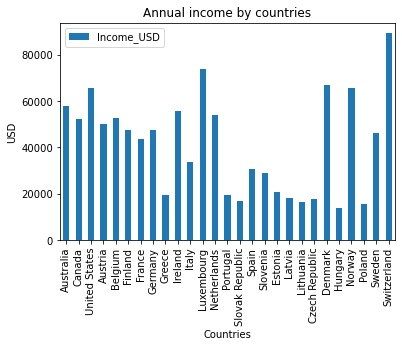

In [24]:
# Exporting the annual income to bar graph
result_df.plot.bar(x='Country',y='Income_USD')

plt.title('Annual income by countries')
plt.xlabel('Countries')
plt.ylabel('USD')


Text(0, 0.5, 'Game price index')

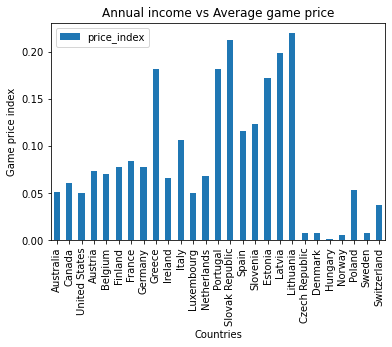

In [25]:
# Exporting the game price index to bar graph
result_df.plot.bar(x='Country',y='price_index')

plt.title('Annual income vs Average game price')
plt.xlabel('Countries')
plt.ylabel('Game price index')

In [26]:
# Exporting result to mongo
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

db = client.isthereanydeal_db
collection = db.priceindex

db.collection.insert_many(result_df.to_dict('records'))

In [29]:
# Exporting result to csv
result_df.to_csv('Output/Regional_price_income.csv')